In [1]:
import yt
import yt.units as u
import sys

## Load the FLASH file

In [4]:
ds = yt.load("../../TDE_plot/multitidal_hdf5_plt_cnt_0100")
ds

yt : [INFO     ] 2020-12-08 20:34:41,841 Parameters: current_time              = 189076.38
yt : [INFO     ] 2020-12-08 20:34:41,842 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2020-12-08 20:34:41,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-12-08 20:34:41,848 Parameters: domain_right_edge         = [7.240177e+13 7.240177e+13 3.620088e+13]
yt : [INFO     ] 2020-12-08 20:34:41,851 Parameters: cosmological_simulation   = 0.0


multitidal_hdf5_plt_cnt_0100

In [3]:
ds.print_stats()

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	     1	           512	             8
  1	     8	          4096	            16
  2	    64	         32768	            32
  3	   512	        262144	            64
  4	   512	        262144	            64
  5	   512	        262144	            64
  6	   512	        262144	            64
  7	   512	        262144	            64
  8	   512	        262144	            64
  9	   512	        262144	            64
 10	   768	        393216	            74
 11	  1768	        905216	            97
 12	  5224	       2674688	           139
 13	 19688	      10080256	           217
----------------------------------------------
   	 31105	      15925760


t = 1.89076380e+05 = 1.89076380e+05 s = 5.99146893e-03 years

Smallest Cell:
	Width: 3.580e-16 Mpc
	Width: 3.580e-10 pc
	Width: 7.385e-05 AU
	Width: 1.105e+09 cm


## Basic Information
### Statistics about the simulation
- Original
- Derived

In [4]:
ds.field_list

[('all', 'particle_accr_rate'),
 ('all', 'particle_accx'),
 ('all', 'particle_accy'),
 ('all', 'particle_accz'),
 ('all', 'particle_blk'),
 ('all', 'particle_creation_time'),
 ('all', 'particle_dtold'),
 ('all', 'particle_gpot'),
 ('all', 'particle_mass'),
 ('all', 'particle_oacx'),
 ('all', 'particle_oacy'),
 ('all', 'particle_oacz'),
 ('all', 'particle_old_pmass'),
 ('all', 'particle_posx'),
 ('all', 'particle_posy'),
 ('all', 'particle_posz'),
 ('all', 'particle_proc'),
 ('all', 'particle_tag'),
 ('all', 'particle_velx'),
 ('all', 'particle_vely'),
 ('all', 'particle_velz'),
 ('all', 'particle_x_ang'),
 ('all', 'particle_x_ang_old'),
 ('all', 'particle_y_ang'),
 ('all', 'particle_y_ang_old'),
 ('all', 'particle_z_ang'),
 ('all', 'particle_z_ang_old'),
 ('flash', 'c12 '),
 ('flash', 'dens'),
 ('flash', 'h1  '),
 ('flash', 'he4 '),
 ('flash', 'temp'),
 ('flash', 'velx'),
 ('flash', 'vely'),
 ('flash', 'velz'),
 ('io', 'particle_accr_rate'),
 ('io', 'particle_accx'),
 ('io', 'particle_

In [5]:
#ds.derived_field_list

### Domain of the simulation

In [6]:
ds.domain_width.in_units("au")

YTArray([4.83975939, 4.83975939, 2.41987936]) au

## Simple Visualization
### Projection
- A line integral through the domain

yt : [INFO     ] 2020-12-08 19:23:19,587 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-08 19:23:19,588 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-08 19:23:19,595 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-08 19:23:19,596 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-08 19:23:19,621 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



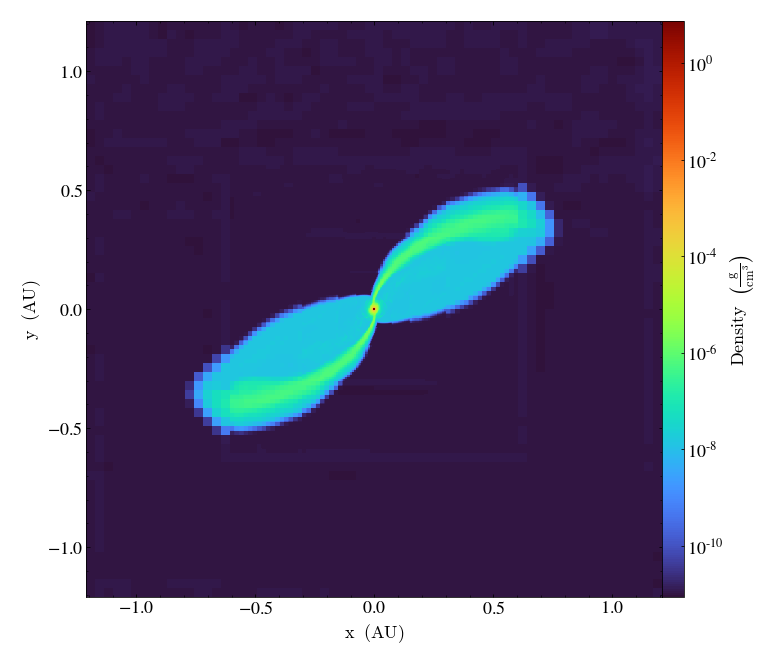

In [8]:
pp = yt.SlicePlot(ds, "z", ["density"])
pp.set_cmap(field="density", cmap='turbo')
pp.zoom(2)

In [8]:
#pp = yt.SlicePlot(ds, "z", ["density"])
#pp.zoom(10)

## Binding Energy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from yt.fields.api import ValidateParameter

In [13]:
edata = np.loadtxt('../../TDE_plot/m0.8_p17_b0.6_P110_extras.dat',
                   dtype='float64')
G = u.gravitational_constant
gmpt = G * edata[6] * u.g

odata = np.loadtxt('../../TDE_plot/m0.8_p17_b0.6_P110_pruned_sinks_evol.dat',
                   dtype='float64')

if odata[0, 14] > odata[1, 14]:
    part_tag_pt = odata[0, 0]
else:
    part_tag_pt = odata[1, 0]
odata_pt = odata[np.where(odata[:, 0] == part_tag_pt)[0]]
odata_ob = odata[np.where(odata[:, 0] != part_tag_pt)[0]]

ptvec = odata_pt[:, 2:8]
obvec = odata_ob[:, 2:8]
boundvec = obvec
time = odata_pt[:, 1]
tindex = abs(time - ds.current_time.v).argmin()


def _bhbound(field, data):
    pos = np.zeros(data['x'].shape, dtype='float64')
    vel2 = pos.copy()
    for i, ax in enumerate(['x', 'y', 'z']):
        pos += (data[ax] - ptvec[tindex, i] * u.cm)**2.
    for i, ax in enumerate(['velx', 'vely', 'velz']):
        vel2 += (data[ax] - ptvec[tindex, i + 3] * u.cm / u.s)**2.
    pot = -gmpt / np.sqrt(pos) + 0.5 * vel2
    return (pot)

def _tfallback(field, data):
    pot = data['bhbound']
    return (gmpt * np.pi / np.sqrt(2) / (-pot)**(3/2))


'''def _selfbound(field, data):
    vel2 = np.zeros(data['x'].shape, dtype='float64')
    V = [data["velx"], data["vely"], data["velz"]]
    for i, ax in enumerate(['velx', 'vely', 'velz']):
        vel2 += (data[ax] - boundvec[tindex, i + 3] * u.cm / u.s)**2.

    pot = 0.5 * data['gpot'] + 0.5 * vel2
    return (pot)'''


yt.add_field(("gas", "bhbound"),
             function=_bhbound,
             units="erg/g",
             take_log=False,
             force_override=True,
             sampling_type="cell")

'''yt.add_field(("gas", "selfbound"),
             function=_selfbound,
             units="erg/g",
             take_log=False,
             force_override=True,
             sampling_type="cell")'''

yt.add_field(("gas", "tfallback"),
             function=_tfallback,
             units="day",
             take_log=False,
             force_override=True,
             sampling_type="cell")

In [14]:
ds = yt.load("../../TDE_plot/multitidal_hdf5_plt_cnt_0100")

yt : [INFO     ] 2020-12-08 21:04:20,192 Parameters: current_time              = 189076.38
yt : [INFO     ] 2020-12-08 21:04:20,193 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2020-12-08 21:04:20,199 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-12-08 21:04:20,201 Parameters: domain_right_edge         = [7.240177e+13 7.240177e+13 3.620088e+13]
yt : [INFO     ] 2020-12-08 21:04:20,203 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2020-12-08 20:36:33,279 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-08 20:36:33,280 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-08 20:36:33,283 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-08 20:36:33,286 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-08 20:36:33,289 Making a fixed resolution buffer of (('gas', 'bhbound')) 800 by 800



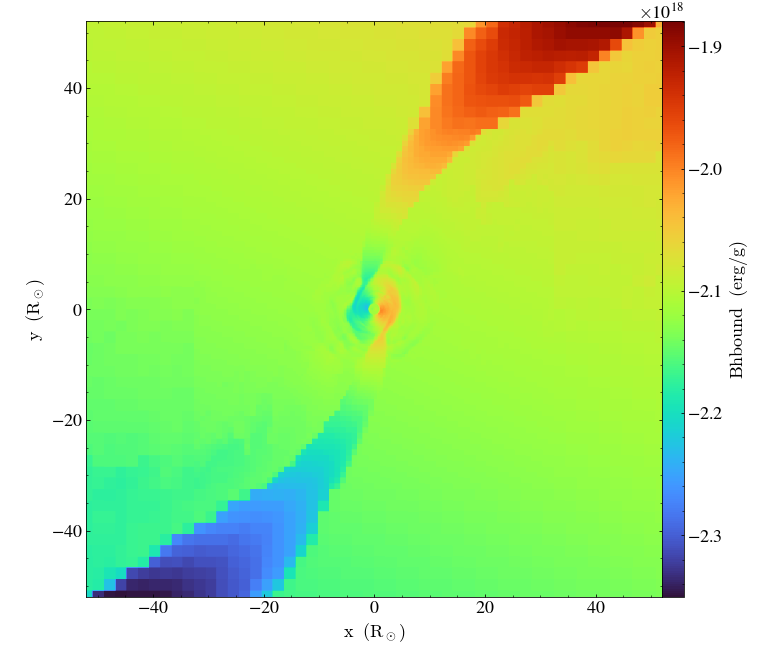

In [8]:
pp = yt.SlicePlot(ds, "z", ["bhbound"])
pp.set_cmap(field="bhbound", cmap='turbo')
pp.zoom(10)